In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast, pickle

from Class_utils.FitnessClasses import *

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
%reload_ext autoreload
%autoreload 2

# Sources Distributions

# Distributions of models' scores

In [2]:
with open("../Models/GlassBox/figs/saved_models/FIGSReg.pkl", 'rb') as file:
    model_figs = pickle.load(file)
with open("../Models/GlassBox/ebm/saved_models/EBMReg.pkl", 'rb') as file:
    model_ebm = pickle.load(file)
with open("../Models/BlackBox/lmart/saved_models/LGBMRanker.pkl", 'rb') as file:
    model_lgbm = pickle.load(file)

In [3]:
dataset0 = pd.read_csv("../outputs/scores/0_dataset.csv")
dataset1 = pd.read_csv("../outputs/scores/1_dataset.csv")

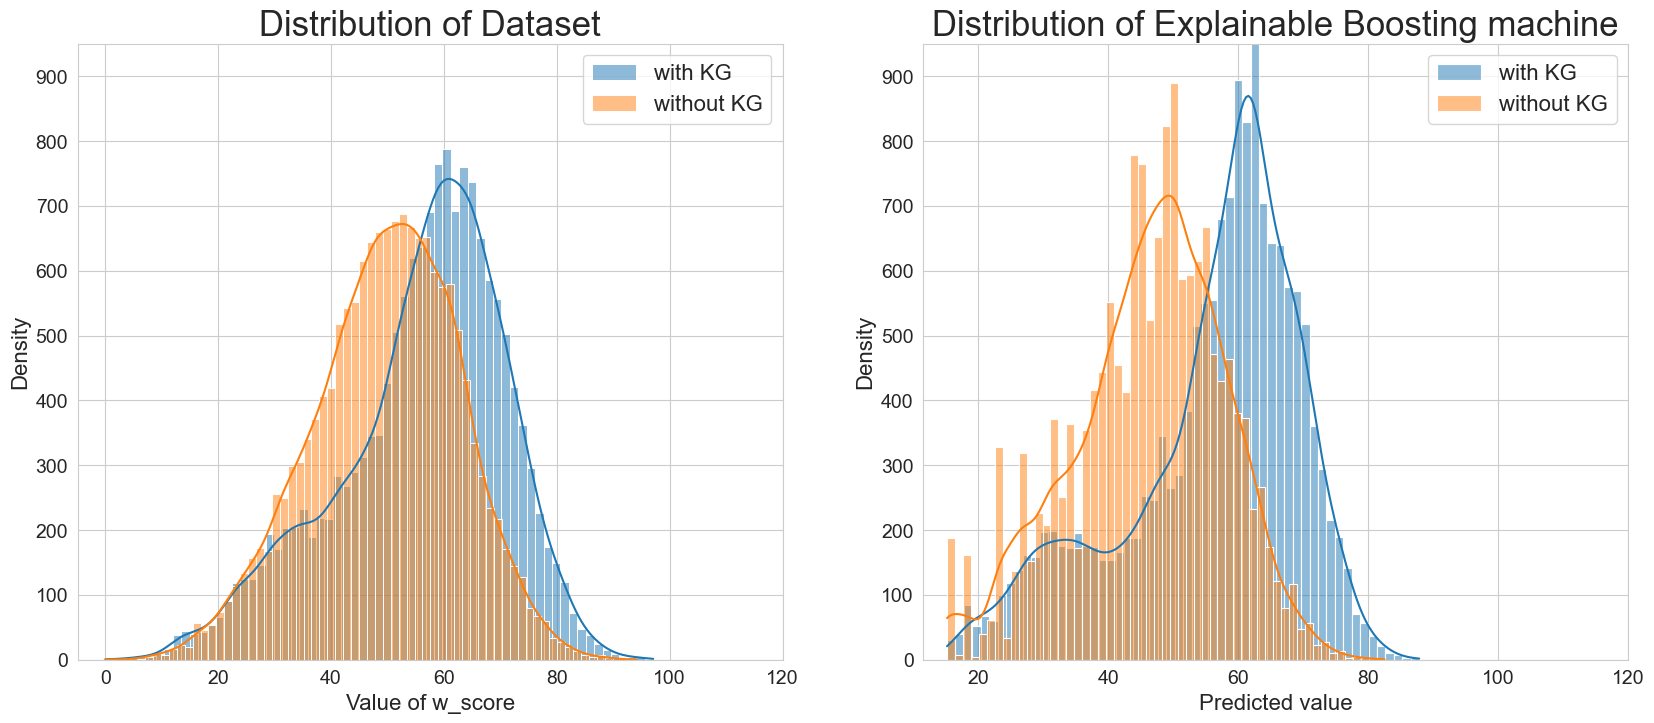

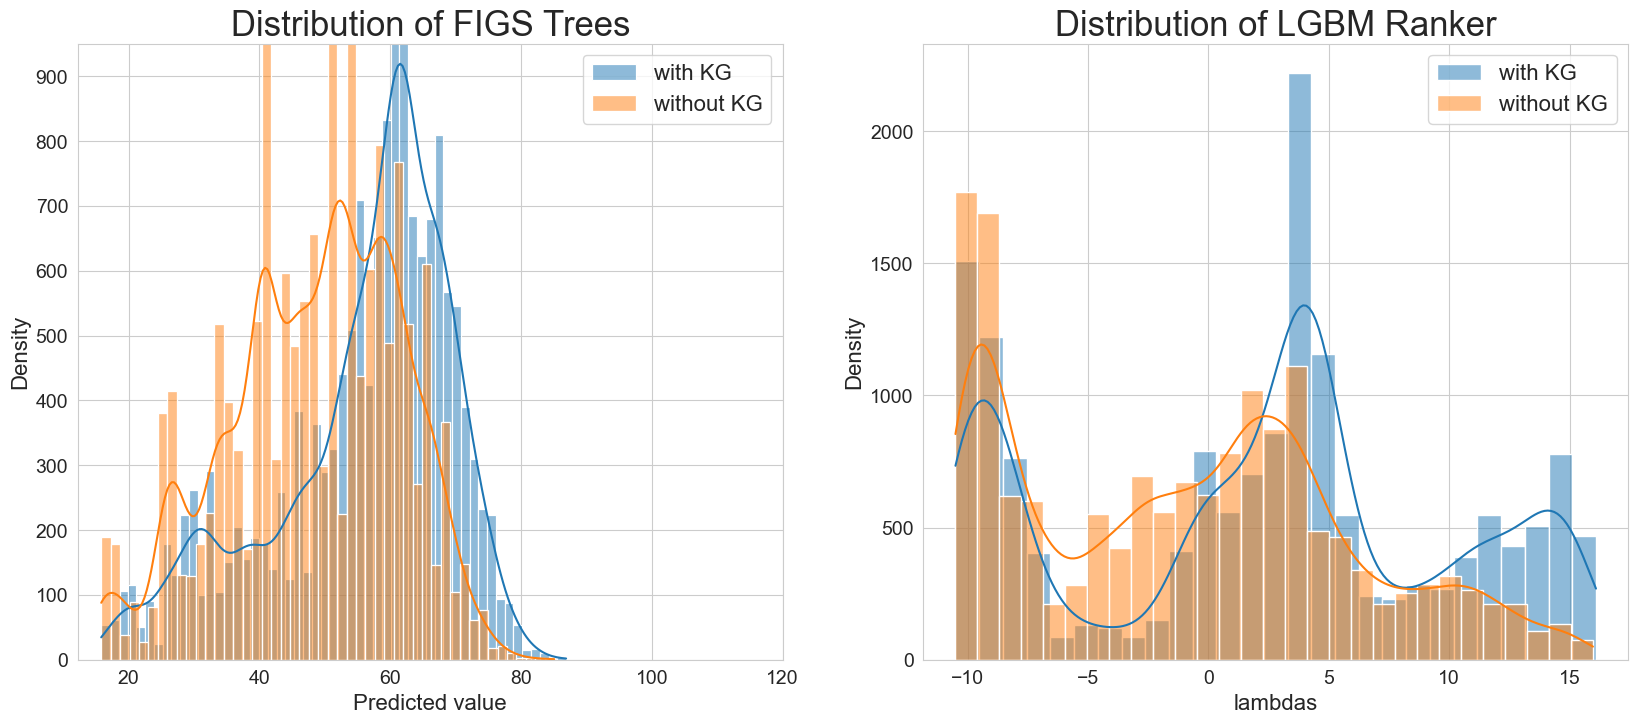

In [4]:

ebm_score0 = model_ebm.predict(dataset0.iloc[:, 5:].to_numpy())
figs_score0 = model_figs.predict(dataset0.iloc[:, 5:].to_numpy())
lgbm_score0 = model_lgbm.predict(dataset0.iloc[:, 5:].to_numpy())
ebm_score1 = model_ebm.predict(dataset1.iloc[:, 5:].to_numpy())
figs_score1 = model_figs.predict(dataset1.iloc[:, 5:].to_numpy())
lgbm_score1 = model_lgbm.predict(dataset1.iloc[:, 5:].to_numpy())

_, axs = plt.subplots(ncols=2, figsize=(20, 8))

sns.histplot(dataset0["w_score"], kde=True, label='with KG', ax=axs[0])
sns.histplot(dataset1["w_score"], kde=True, label='without KG', ax=axs[0])
axs[0].set_title('Distribution of Dataset', fontsize=25)
axs[0].set_xlabel('Value of w_score', fontsize=16)
axs[0].set_ylabel("Density", fontsize=16)
axs[0].set_xticks(axs[0].get_xticks()[1:])
axs[0].set_yticks(axs[0].get_yticks())
axs[0].set_ylim([0, 950])
axs[0].tick_params(axis='both', labelsize=14)
axs[0].legend(fontsize=16)
axs_x0 = axs[0].get_xticks()[1:]
axs_y0 = axs[0].get_yticks()

sns.histplot(ebm_score0, kde=True, label='with KG', ax=axs[1])
sns.histplot(ebm_score1, kde=True, label='without KG', ax=axs[1])
axs[1].set_title('Distribution of Explainable Boosting machine', fontsize=25)
axs[1].set_xlabel('Predicted value', fontsize=16)
axs[1].set_ylabel("Density", fontsize=16)
axs[1].set_xticks(axs_x0)
axs[1].set_yticks(axs_y0)
axs[1].set_ylim([0,950])
axs[1].tick_params(axis='both', labelsize=14)
axs[1].legend(fontsize=16)

plt.show()

_, axs = plt.subplots(ncols=2, figsize=(20, 8))

sns.histplot(figs_score0, kde=True, label='with KG', ax=axs[0])
sns.histplot(figs_score1, kde=True, label='without KG', ax=axs[0])
axs[0].set_title('Distribution of FIGS Trees', fontsize=25)
axs[0].set_xlabel('Predicted value', fontsize=16)
axs[0].set_ylabel("Density", fontsize=16)
axs[0].set_xticks(axs_x0)
axs[0].set_yticks(axs_y0)
axs[0].set_ylim([0, 950])
axs[0].tick_params(axis='both', labelsize=14)
axs[0].legend(fontsize=16)

sns.histplot(lgbm_score0, kde=True, label='with KG', ax=axs[1])
sns.histplot(lgbm_score1, kde=True, label='without KG', ax=axs[1])
axs[1].set_title('Distribution of LGBM Ranker', fontsize=25)
axs[1].set_xlabel('lambdas', fontsize=16)
axs[1].set_ylabel("Density", fontsize=16)
axs[1].tick_params(axis='both', labelsize=14)
axs[1].legend(fontsize=16)

plt.show()


# Consistent curricula

In [5]:
curricula = pd.read_csv("../outputs/0_curricula.csv",usecols=[0,1,2]).set_index("kId")
dataset = pd.read_csv("../outputs/scores/0_dataset.csv").set_index("kId")

In [6]:
curricula = pd.concat([curricula, pd.json_normalize(curricula['metadata'].apply(ast.literal_eval))],
                      axis=1)["consistent"]
curricula.index.rename("kId", inplace=True)

curricula = dataset.merge(curricula, on="kId")[["w_score","consistent"]]
curricula['consistent'] = curricula['consistent'].astype(int)
lambda_figs = model_figs.predict(dataset.iloc[:, 4:].to_numpy())
lambda_ebm = model_ebm.predict(dataset.iloc[:, 4:].to_numpy())
lambda_lgbm = model_lgbm.predict(dataset.iloc[:, 4:].to_numpy())

predictions = [
    pd.DataFrame({'score': lambda_lgbm, 'ax_': np.ones_like(lambda_lgbm.T) * 4, 'c': curricula['consistent']}),
    pd.DataFrame({'score': lambda_figs, 'ax_': np.ones_like(lambda_figs.T) * 3, 'c': curricula['consistent']}),
    pd.DataFrame({'score': lambda_ebm, 'ax_': np.ones_like(lambda_ebm.T) * 2, 'c': curricula['consistent']}),
    pd.DataFrame({'score': curricula["w_score"].to_numpy(), 'ax_': np.ones_like(curricula["w_score"].to_numpy().T) * 1, 'c': curricula['consistent']})
]

predictions = pd.concat(predictions)

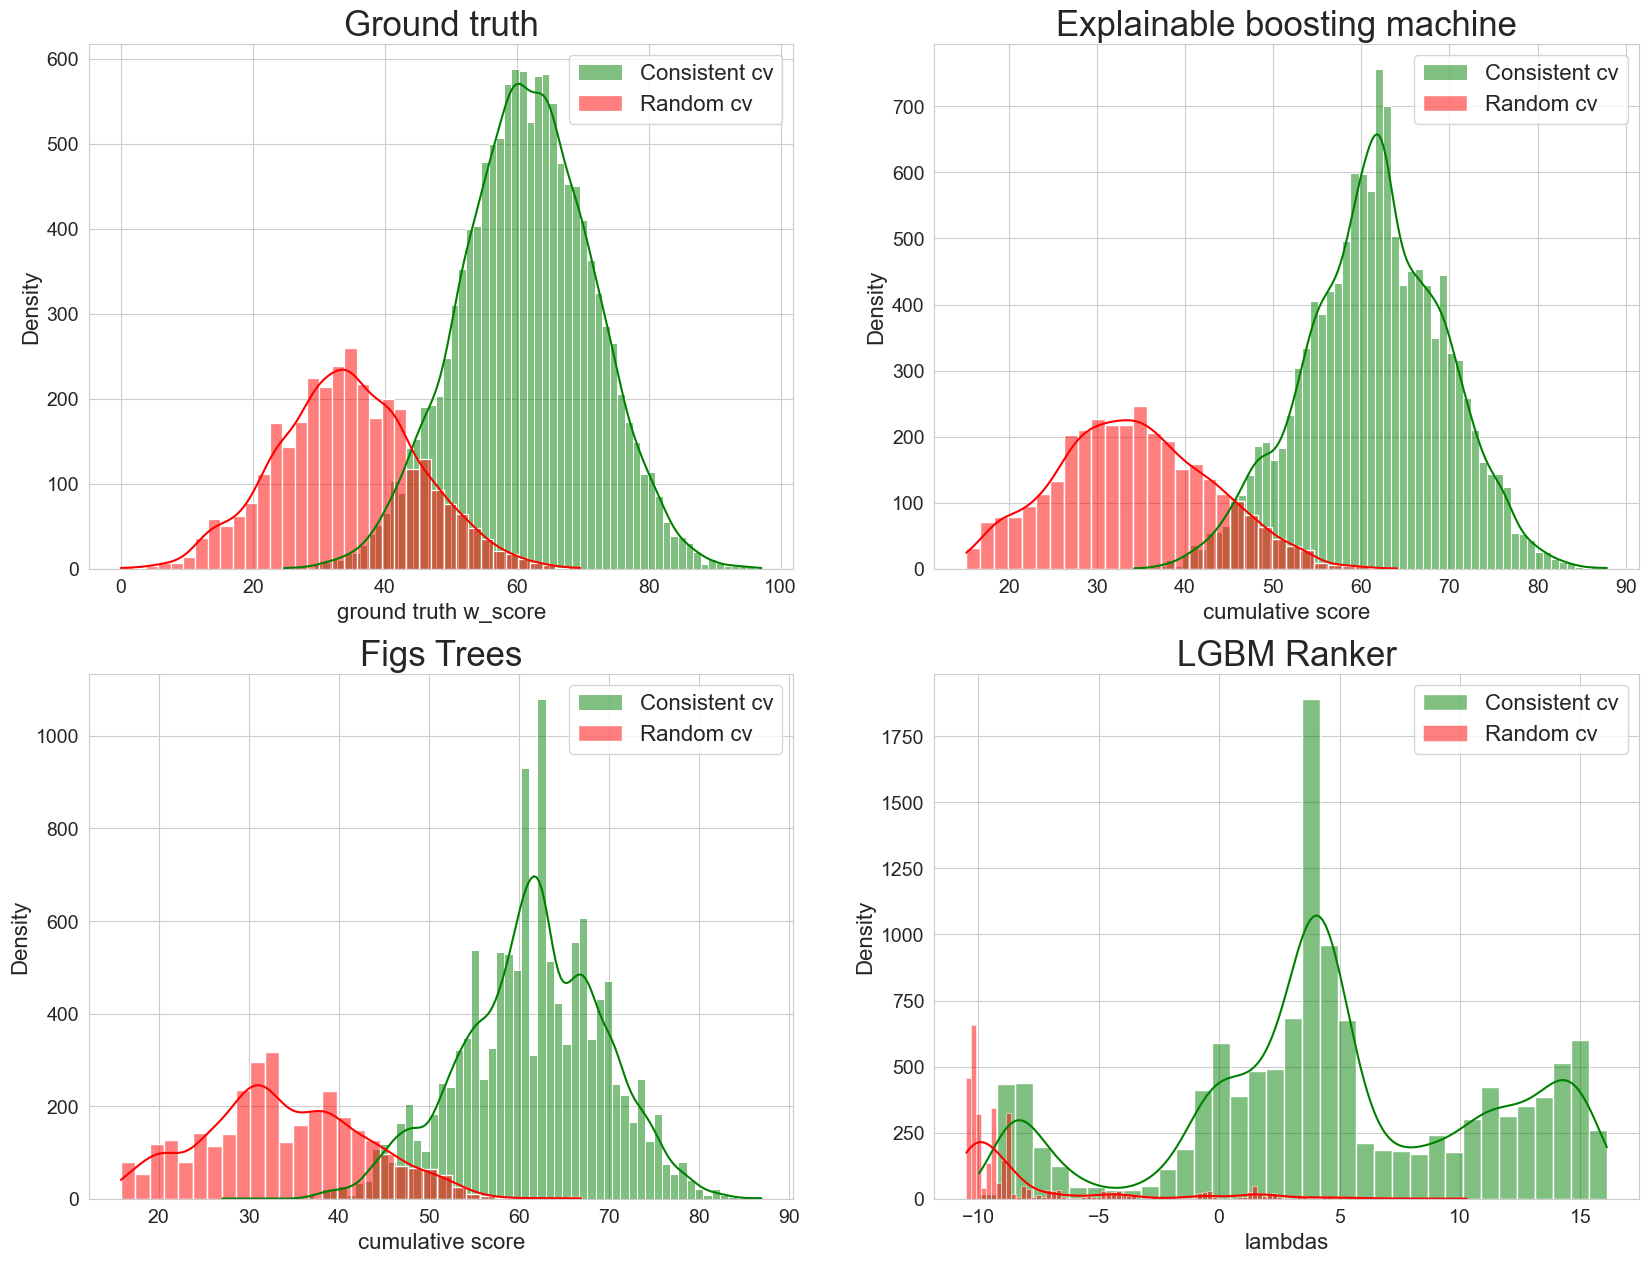

In [7]:
_, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

models = [1, 2, 3, 4]
titles = ["Ground truth", "Explainable boosting machine", "Figs Trees", "LGBM Ranker"]
labels = ["ground truth w_score", "cumulative score", "cumulative score", "lambdas"]

for i, model in enumerate(models, start=1):
    consistent_data = predictions[(predictions["c"] == 1) & (predictions["ax_"] == model)]["score"]
    random_data = predictions[(predictions["c"] == 0) & (predictions["ax_"] == model)]["score"]

    sns.histplot(consistent_data, kde=True, color="green", label="Consistent cv", ax=axs.flatten()[i-1])
    sns.histplot(random_data, kde=True, color="red", label="Random cv", ax=axs.flatten()[i-1])

    axs.flatten()[i-1].set_title(titles[i-1], fontsize=25)
    
    axs.flatten()[i-1].set_xlabel(labels[i-1], fontsize=16)
    axs.flatten()[i-1].set_ylabel("Density", fontsize=16)
    axs.flatten()[i-1].tick_params(axis='both', labelsize=14)    
    axs.flatten()[i-1].legend(fontsize=16)

plt.show()